In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from jcopml.pipeline import cat_pipe,num_pipe
from jcopml.tuning import grid_search_params as gsp
from jcopml.plot import plot_missing_value


# import data

In [3]:
df= pd.read_csv("data/mushrooms.csv")
df.head()

,edible,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,stalk_shape,stalk_root,stalk_surface_above_ring,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,False,convex,smooth,brown,True,pungent,free,close,narrow,black,enlarging,equal,smooth,smooth,white,white,partial,white,1,pendant,black,scattered,urban
1,True,convex,smooth,yellow,True,almond,free,close,broad,black,enlarging,club,smooth,smooth,white,white,partial,white,1,pendant,brown,numerous,grasses
2,True,bell,smooth,white,True,anise,free,close,broad,brown,enlarging,club,smooth,smooth,white,white,partial,white,1,pendant,brown,numerous,meadows
3,False,convex,scaly,white,True,pungent,free,close,narrow,brown,enlarging,equal,smooth,smooth,white,white,partial,white,1,pendant,black,scattered,urban
4,True,convex,smooth,gray,False,none,free,crowded,broad,black,tapering,equal,smooth,smooth,white,white,partial,white,1,evanescent,brown,abundant,grasses


In [21]:
df.ring_number.value_counts()

1    7488
2     600
0      36
Name: ring_number, dtype: int64

# liat jumlah data target jika klasifikasi, balance atau imbalance

In [5]:
df.edible.value_counts()

True     4208
False    3916
Name: edible, dtype: int64

ternyata lumayan balance

,missing_value,%
edible,0,0.00
cap_shape,0,0.00
cap_surface,0,0.00
cap_color,0,0.00
bruises,0,0.00
odor,0,0.00
gill_attachment,0,0.00
gill_spacing,0,0.00
gill_size,0,0.00
gill_color,0,0.00


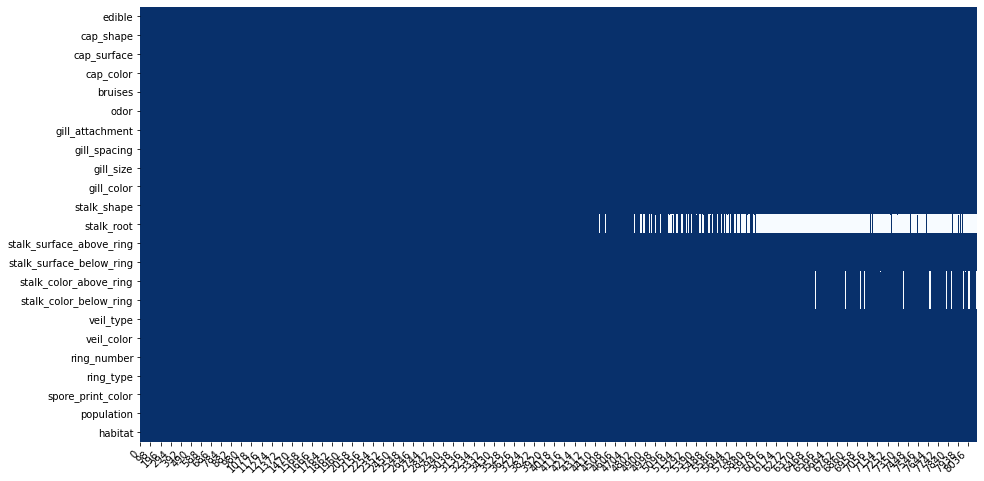

In [8]:
plot_missing_value(df,return_df=True)

# Association Matrix

In [6]:
from jcopml.plot import plot_association_matrix

In [10]:
plot_association_matrix(df, df.edible, categoric_col='auto')

ValueError: Categorical column should have at least 2 category
You should remove these column from your data -> veil_type

In [12]:
df.veil_type.value_counts()

partial    8124
Name: veil_type, dtype: int64

In [14]:
df.drop(columns='veil_type',inplace=True)

In [16]:
plot_association_matrix(df, "edible", categoric_col='auto')

interactive(children=(ToggleButtons(description='method', options=("Cramer's V", 'Proficiency U(X|Y)', 'Profic…

# Dataset Splitting

In [20]:
X=df[['odor','gill_color','ring_type', 'spore_print_color']]
y=df.edible

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5443, 4), (2681, 4), (5443,), (2681,))

# training
* karna data X nya udah di definisikan setelah melihat plot dari association matrix, maka jelas terlihat bahwa semua kolom feature (X) adalah kolom kategori

In [22]:
from sklearn.linear_model import LogisticRegression

In [24]:
preprocessor= ColumnTransformer([
    ('categoric', cat_pipe(encoder='onehot'),X_train.columns)
])

pipeline=Pipeline([
    ('prep',preprocessor),
    ('algo',LogisticRegression(random_state=42,n_jobs=-1))
])

model= GridSearchCV(pipeline, gsp.logreg_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train,y_train)

print(model.best_params_)
print(model.score(X_train,y_train),model.best_score_ , model.score(X_test,y_test))


Fitting 3 folds for each of 14 candidates, totalling 42 fits
{'algo__C': 10.0, 'algo__fit_intercept': True}
0.9941208892155061 0.9941210238093069 0.9955240581872435


In [25]:
preprocessor= ColumnTransformer([
    ('categoric', cat_pipe(encoder='onehot'),X_train.columns)
])

pipeline=Pipeline([
    ('prep',preprocessor),
    ('algo',LogisticRegression(multi_class='multinomial',random_state=42,n_jobs=-1))
])

model= GridSearchCV(pipeline, gsp.logreg_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train,y_train)

print(model.best_params_)
print(model.score(X_train,y_train),model.best_score_ , model.score(X_test,y_test))


Fitting 3 folds for each of 14 candidates, totalling 42 fits
{'algo__C': 10.0, 'algo__fit_intercept': True}
0.9941208892155061 0.9941210238093069 0.9955240581872435


# feature importance

In [26]:
from jcopml.feature_importance import mean_score_decrease

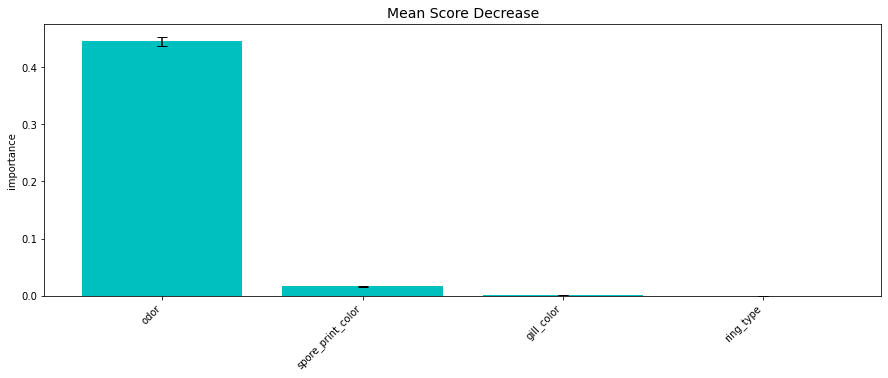

In [27]:
df_imp = mean_score_decrease(X_train, y_train, model, plot=True, topk=10)

# evaluation
* matrix confusion, report, roc, pr

In [28]:
from jcopml.plot import plot_confusion_matrix,plot_classification_report,plot_pr_curve,plot_roc_curve

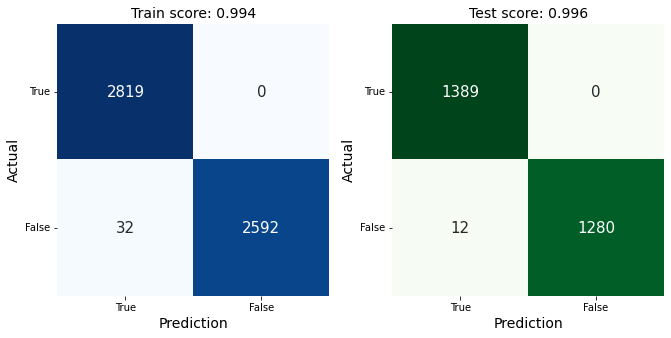

In [29]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)

terlihat bahwa ada yang false yang seharusnya di actual malah kita prediksi true, maka perlu difokuskan pada true negative tersebut

In [30]:
plot_classification_report(X_train, y_train, X_test, y_test, model, report=True)

Train report
              precision    recall  f1-score   support

       False       1.00      0.99      0.99      2624
        True       0.99      1.00      0.99      2819

    accuracy                           0.99      5443
   macro avg       0.99      0.99      0.99      5443
weighted avg       0.99      0.99      0.99      5443


Test report
              precision    recall  f1-score   support

       False       1.00      0.99      1.00      1292
        True       0.99      1.00      1.00      1389

    accuracy                           1.00      2681
   macro avg       1.00      1.00      1.00      2681
weighted avg       1.00      1.00      1.00      2681



sudah terlihat dari report bahwa dari matrix precision recal dan f1 nya udah cukup baik. berarti model kita korelasi nya udah lumayan baik

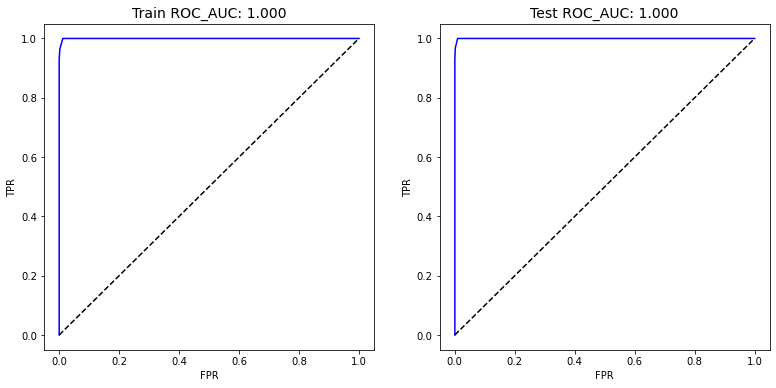

In [31]:
plot_roc_curve(X_train, y_train, X_test, y_test, model)

di plot roc juga udah menunjukkan kurva yang baik

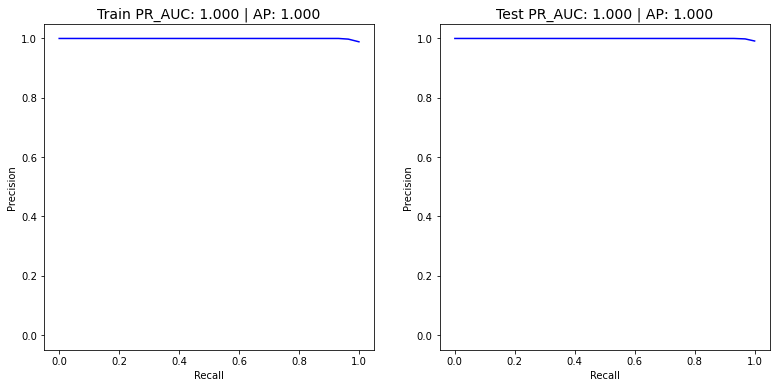

In [32]:
plot_pr_curve(X_train, y_train, X_test, y_test, model)

# insight from data

C:\Users\Rahmat\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Rahmat\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Rahmat\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Rahmat\anaconda3\li

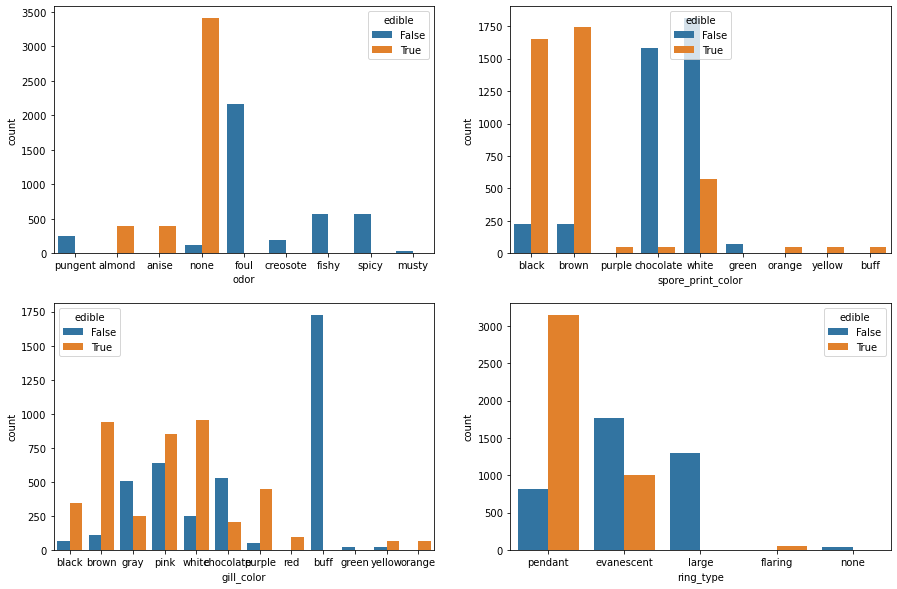

In [36]:
import seaborn as sns

plt.figure(figsize=(15,10))
plt.subplot(221)
sns.countplot('odor', data=df, hue='edible')
plt.subplot(222)
sns.countplot('spore_print_color', data= df, hue= 'edible')
plt.subplot(223)
sns.countplot('gill_color', data=df, hue= 'edible')
plt.subplot(224)
sns.countplot('ring_type', data=df, hue= 'edible')

insight dari data odor terhadap edible atau not edible terlihat bahwa yang tidak berbau (odor) related dengan edible, dan yang not edible related dengan odor yang foul, creasote, fishy, spicy, musty, dll. pada data spore_print_color insight yang bisa diambil bahwa warna spore yang brown dan hitam related dengan edible walaupun ada sebagian ada yang not edible, dan yang warna putih dan chocolate lebih cenderung related dengan not edible. begitu juga analisis data seterus nya.

# correlation ratio

In [37]:
from jcopml.plot import plot_correlation_ratio

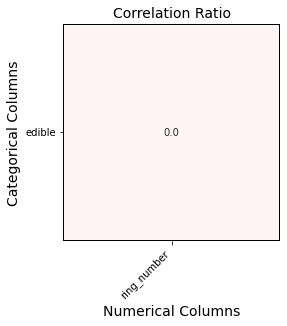

In [38]:
plot_correlation_ratio(df, ['edible'],['ring_number'] )

terlihat bahwa korelasi antara feature yang numerik tidak ada hubungan nya dengan target kategorik kita tadi